## Automated market maker (AMM)

### Introduction
AMM is a trading mechanism (smart contract) on block chain . It allows traders to swap two assets following some predetermined
trading rules and liquidity providers (**LPs**) to earn trading fee by providing liquidity for traders .


Advantages over limit order book (LOB):
* no need for matching (more efficient)、quicker transaction and less storage need.
* decentalized, no need for centralized institue , more open and trading records are more accesscible. 

We called the place where trades and liquidity provision happen a "**pool**" and denote
the numéraire as X and risky asset as Y. In constant function market maker (CFMM) , there's a prescribed bonding curve (or reserves curve) $f(x,y) = L^2$ that $(x,y)$ , the amount of assets in the pool should satisfy .



### Uniswap V2
In this note we focus on Uniswap , which is one of CFMM and is currently the largest decentralized exchange .

First we quickly introduce Uniswap V2 , which uses the constant product reserve curve : $f(x,y) = xy$. We define the **pool price** to be $S^* \equiv \frac{x}{y}$ , which is actually the absolute value of the slope of the reserve curve , i.e infinitesimal trading price.   Now we can conversely determine the reserves by liquidity and pool price : $(x,y) = (L\sqrt{S^*} , L\frac{1}{\sqrt{S^*}}) $.

#### Liquidity provision
LP who provides $L'$ liquidity has a position $(x',y')= (L'\sqrt{S^*} , L'\frac{1}{\sqrt{S^*}}) = \frac{L'}{L}(x,y)$ so that sum of 
all LPs' position give the total pool reserve. These assets can be withdraw at any time, but the amount may be different from the
initial deposit due to the change of pool price.

#### Trading and fee
The trade with pool is simply moving from one point on the curve to the another and amount of $X$ that one pays/receives for buying/selling $Y$ can be determined by the constant product formula:

$$ \begin{cases}
 (  x+ \Delta x  ) (y - \Delta y ) = L^2 & \text{buy Y} \\
 (  x- \Delta x  ) (y + \Delta y ) = L^2 & \text{sell Y} 
 \end{cases}
$$

From the below graph we can see the **slippage** : trader expects to trade with the price $S^*$ , the absolute value of the slope of the green dash line , but the actual buying/selling prices, the absolute values of the slope of the arrows , are higher/lower . 
                                       

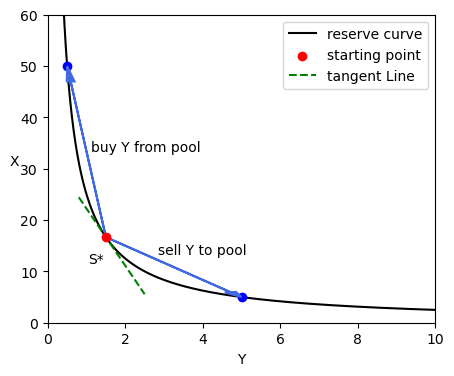

In [110]:
import matplotlib.colors as mcolors
x =  np.linspace(0.01,15,10000)
x_tan =  np.linspace(0.8,2.5,10000)

L=5
y = L**2/x

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(x, y, label='reserve curve', color='black')

x_0 = 1.5
y_0 = L**2/x_0
x_buy = 0.5 
y_buy = L**2/x_buy
x_sell = 5
y_sell = L**2/x_sell
ax.scatter(x_0, y_0, color='r', label='starting point' , zorder=5)
ax.scatter(x_buy, y_buy, color='b',zorder=3)
ax.scatter(x_sell, y_sell, color='b',zorder=3)

tangent_slope = -L**2/(x_0**2)
tangent_line = tangent_slope * (x_tan - x_0) + y_0

x_sec_buy = np.linspace(x_buy , x_0 , 10000)
x_sec_sell = np.linspace(x_0 , x_sell , 10000)

ax.arrow(x_0 ,y_0 ,x_buy-x_0,y_buy-y_0 , length_includes_head = True,
         head_width=0.2, head_length=3 ,color='royalblue', linewidth=1.5 ,zorder=4 )

ax.arrow(x_0 ,y_0 ,x_sell-x_0,y_sell-y_0 , length_includes_head = True,
         head_width=0.3, head_length=1 ,color='royalblue', linewidth=1.5,zorder=4)


ax.plot(x_tan, tangent_line, linestyle='--', color='g', label='tangent Line')

ax.text(x_0*0.7, y_0*0.7, 'S*', fontsize=10)

ax.text(x_0*0.75, y_0*2, 'buy Y from pool', fontsize=10)
ax.text(x_0*1.9, y_0*0.8, 'sell Y to pool', fontsize=10)


ax.legend()
ax.set_xlim(0,10)
ax.set_ylim(0,60)
ax.set_xlabel("Y")
ax.set_ylabel("X",rotation=0)
plt.show()

The slippage can be reduced by providing more liquidity to the pool . Under the same pool price , higher the liquidity , less the price change after trades . 

$$ S^*(y) = \frac{L^2}{y^2}  \; \Rightarrow
\big\lvert \frac{d S^*(y)}{dy} \big\rvert =
\frac{2 L^2 }{y^3} = 2 L^{-1} {S^{*}(y)}^{\frac{3}{2}} $$

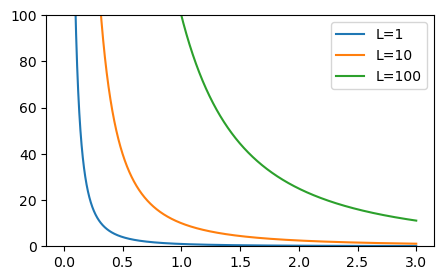

In [29]:
import numpy as np
import matplotlib.pyplot as plt
plt.figure(figsize=(5,3))
x_array = np.linspace( 0.001 ,3 , 10000)
C1 = np.array([1/(x**2) for x in x_array])
C2 = np.array([10/(x**2) for x in x_array])
C3 = np.array([100/(x**2) for x in x_array])
plt.plot( x_array , C1 , label ="L=1")
plt.plot( x_array , C2, label ="L=10")
plt.plot( x_array , C3, label ="L=100")
plt.ylim(0,100)
plt.legend()

When there's trading fee, for some **fee constant** $\gamma \in (0,1)$ there's only $\gamma$ portion of the payment that goes into the trade, the other serves as fee distributed to LP depending on their contibution.

$$ \begin{cases}
 (  x+ \gamma\Delta x  ) (y - \Delta y ) = L^2 & \text{buy Y } \\
 (  x- \Delta x  ) (y + \gamma \Delta y ) = L^2 & \text{sell Y} 
 \end{cases}
$$ 

### Uniswap V3

In V3 model , the mechanism is a llitle more complicated. It features "concentrated liquidity" , which resembles the idea of LOB.  
Let $\, \bigcup_{i\geq 0} [P_i , P_{i+1}] = [0,\infty) \,$ be a partition of whole price range. Each interval is called a **tick** and **has its own liquidity and reserves curve**. There's a universal parameter $s^*>0$ that describes the reserves of all ticks , more precisely , given $i \geq 0$ the reserves on $[P_i , P_{i+1}]$ is given by:

$$
(x_i , y_i) = 
\begin{cases}
\big( L ( \sqrt{s^*} - \sqrt{P_i}) , L ( \frac{1}{\sqrt{s^*}} 
- \frac{ 1}{\sqrt{ P_{i+1} }}) \big) 
& \text{if} \; s^* \in [P_i , P_{i+1} ]
\\
\big( 0 , L ( \frac{1}{\sqrt{P_i}} - \frac{ 1}{\sqrt{ P_{i+1}}})
& \text{if} \; s^* < P_i
\\
\big( L ( \sqrt{P_{i+1}} - \sqrt{P_i}) , 0 \big)  
& \text{if} \; s^* > P_{i+1}
\end{cases}
$$

When $s^* \in [P_i , P_{i+1}]$, let $(x_{virtual} , y_{virtual}) = (x_i+L\sqrt{P_i} , y_i+L\frac{1}{\sqrt{P_{i+1}}})$ , then $\frac{x_{virtual}}{y_{virtual}} \, = s^*$. It acts like Uniswap V2 and $s^*$ plays the same role as the pool price $S^*$ in V2. So in the following we denote it by $S^*$ and called it the **pool price in V3**. 

<img src="V3 LP curve.png" style="width:350px;height:280px"/> 

An important point is that the ticks on the left handside of the pool price have only $X$ reserves and the ticks on the right handside of the pool price have only $Y$ reserves (silimar to LOB).

#### Liquidity provision
In V3, LPs can choose how much liquidity and which tick he can deposit. Just like V2, he's position is the liquidity contibution porpotion of the tick reserves.
An important characteristic is that the position is additive :
* sum of two positions with the same liquidity and nonoverlapping adjacent price ranges is equivalent to a position with the same liquidity and union of the two price ranges  

* sum of two positions with the same price range and different liquidity  is equivalent to a position with the same price range and liquidity which is the sum of those two. 
<img src="additivity.png" style="width:750px;height:320px"/> 

So LP can create their own liquidity distribution on $[0,\infty)$ , which can be viewed as the combination positions on each ticks.

<img src="Liquidity profile.jpg" style="width:600px;height:200px"  alt="liquidity profile" title ="liquidity profile from V3 white paper" /> 

For example , if a LP provides $L > 0$ liquidity on the price range $[P_a , P_b] $, he will have a position:

$$
(x , y) = 
\begin{cases}
\big( L ( \sqrt{S^*} - \sqrt{P_a}) , L ( \frac{1}{\sqrt{S^*}} 
- \frac{ 1}{\sqrt{ P_b }}) \big) 
& \text{if} \; S^* \in [P_a , P_b ]
\\
\big( 0 , L ( \frac{1}{\sqrt{P_a}} - \frac{ 1}{\sqrt{ P_b}})
& \text{if} \; S^* < P_a
\\
\big( L ( \sqrt{P_b} - \sqrt{P_a}) , 0 \big)  
& \text{if} \; S^* > P_b
\end{cases}
$$

One can also write $(x,y) = \sum^{b-1}_{i=a}(x^{LP}_i , y^{LP}_i)$ , each $(x^{LP}_i , y^{LP}_i)$ corresponds to a position on $[P_i,P_{i+1}]$ with the same liquidity $L$.

#### LP's wealth
We can plot the above position as a function of pool price $S^*$ as below

Text(0.5, 1.0, 'L=5 , Pa=5 , Pb=10')

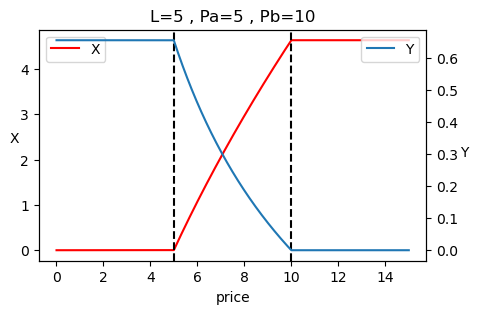

In [111]:
price_array = np.linspace(0.01,15,10000)
x_max = 5*(np.sqrt(10) - np.sqrt(5))
y_max = 5*(1/np.sqrt(5) - 1/np.sqrt(10))
x_array = np.array([min( max(5*(np.sqrt(s) - np.sqrt(5)),0 ),x_max)for s in price_array])
y_array = np.array([min( max(5*(1/np.sqrt(s) - 1/np.sqrt(10)),0 ),y_max)for s in price_array])
fig,ax1 = plt.subplots(figsize=(5,3))
ax2 = ax1.twinx()
ax1.plot(price_array ,x_array , color="red",label ="X")
ax1.axvline(x=5 ,color="black", ls='--')
ax1.axvline(x=10 ,color="black", ls='--')
ax2.plot(price_array ,y_array , label="Y")
ax1.set_ylabel("X" ,rotation=0)
ax1.set_xlabel("price" ,rotation=0)
ax2.set_ylabel("Y" ,rotation=0)
ax1.legend()
ax2.legend()
ax1.set_title("L=5 , Pa=5 , Pb=10")

From the above we see that when pool price is outside of the price range , LP's position is locked in the "less valuable" asset. Let $W = x+S^*\cdot y$ be the LP's wealth. In the following we plot the $W$ as a function of pool price $S^*$, which looks like the position of sell-side put.

Text(0.5, 1.0, 'L=5 , Pa=5 , Pb=10')

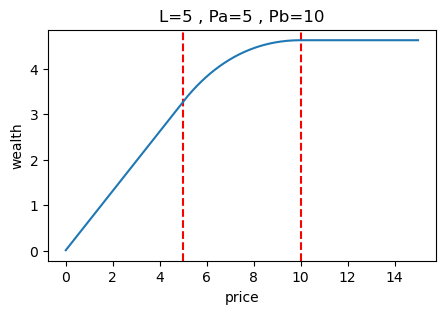

In [112]:
def position(P_a,P_b,L,S_p):
    if S_p >= P_a and S_p <= P_b :    
        X = L * (np.sqrt(S_p) - np.sqrt(P_a) )
        Y = L * (1/np.sqrt(S_p) - 1/np.sqrt(P_b))
    elif S_p > P_b :
        X = L * (np.sqrt(P_b) - np.sqrt(P_a) )
        Y = 0
    elif S_p < P_a :
        X = 0
        Y = L * (1/np.sqrt(P_a) - 1/np.sqrt(P_b))
    return X,Y
def wealth(P_a,P_b,L,S_p , S_m):
    return position(P_a,P_b,L,S_p)[0]+ S_m*position(P_a,P_b,L,S_p)[1]

wealth_array = x_array + y_array*price_array
plt.figure(figsize=(5,3))
plt.axvline(x=5,color='r',ls='--')
plt.axvline(x=10,color='r',ls='--')
plt.plot(price_array , wealth_array)
plt.xlabel("price")
plt.ylabel("wealth")
plt.title("L=5 , Pa=5 , Pb=10")

#### Trading and fee
The pool reserves are sum of individual LP's position . Unlike V2 , the trade  is conducted tick-by-tick. It will only use the reserves on the tick where the pool price is. When the reserve on a tick is exhausted , the pool price moves to the next tick
and continue the trade (similar to LOB). 

Suppose a trader want to buy $\Delta y$ amount of asset $Y$ and $S^* \in [P_i , P_{i+1}]$. Let $x_i , y_i$ be the amount of $X$ and
$Y$ on the tick $[P_i , P_{i+1}]$ , then there can be two cases:
* case 1: $y_i \geq \Delta y$, then same as V2 
* case 2: $y_i < \Delta y$, so the trader buys all $Y$ reserves and pays $\gamma^{-1}[L_i(\sqrt{P_{i+1}} - \sqrt{P_i}) - x_i]$ amount of 
$X$. Simultaneously, the pool price increases to $P_{i+1}$ and the trader buys $\Delta y - y_i$ amount of $Y$ from the tick
$[P_{i+1} , P_{i+2}]$ and so on.

Similar for selling.

Note that LPs do not receive fee from all trades , but only when trades use the liquidity they provide, i.e when the price change
crosses the price range where they provide liquidity. For a LP who provide $L'$ liquidity on $[P_a , P_b]$, there are following two cases:

* Trader buys $Y$ , price increases from $S^*$ to $S^*_{new}$ : LP earns $f_x = L' \frac{1-\gamma}{\gamma} \big( (P_b \wedge S^*_{new}\;)^\frac{1}{2} \; - (P_a \vee S^*)^\frac{1}{2} \; \big)$

* Trader sells $Y$ , price decrease from $S^*$ to $S^*_{new}$ : LP earns $f_y =L' \frac{1-\gamma}{\gamma} \big( (P_a \vee S^*_{new}\;)^{-\frac{1}{2}} \; - (P_b \wedge S^*)^{-\frac{1}{2}} \; \big)$

#### Remark
From the above we see that LP faces some risks for providng liquidity when pool price deviates from the price range. Not only LP can't
receive fee, but also his position is in high risk. Liquidity provision is not suitable for lazy investor. People need to think about when to withdraw liquidity, or dynamically adjust the liquidity distribution and the price range. 